In [1]:
# Import all the necessary libraries 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

In [2]:
# Load the dataset

path = "/Users/rohityadav/Desktop/Git Projects/ml-credit-risk-modeling/data/train.csv"
df = pd.read_csv(path)
df.drop(columns = ['Loan_ID'], errors = 'ignore', inplace = True)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Encode the Loan_Status values

df['default'] = df['Loan_Status'].map({'Y': 0, 'N': 1})

X = df.drop(columns = ['Loan_Status', 'default'], errors = 'ignore')
y = df['default']

y.value_counts(normalize = True)

default
0    0.687296
1    0.312704
Name: proportion, dtype: float64

In [4]:
# Train, Test and Split (Stratfied)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

X_train.shape, X_test.shape

((491, 11), (123, 11))

In [5]:
# Define feature groups

categorical_features = [
    'Gender',
    'Married',
    'Dependents',
    'Education',
    'Self_Employed',
    'Property_Area'
]

numerical_features = [
    'ApplicantIncome',
    'CoapplicantIncome',
    'LoanAmount',
    'Loan_Amount_Term',
]

credit_history_feature = ['Credit_History'] 

In [6]:
# Build preprocessing (mode, median + OneHot + Scaling)

# for categorical 
categorical_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# for numerical
numerical_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

# for credit_history
credit_history_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', categorical_pipeline, categorical_features),
        ('num', numerical_pipeline, numerical_features),
        ('ch', credit_history_pipeline, credit_history_feature)
    ],
    remainder = 'drop'
)

In [7]:
# Fit preprocessing on train, transform train and test  

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print('X_train_processed', X_train_processed.shape)
print('X_test_processed', X_test_processed.shape)

X_train_processed (491, 20)
X_test_processed (123, 20)


In [8]:
# Train Logistic Regression

log_reg = LogisticRegression(
    max_iter = 1000,
    solver = 'lbfgs',
    random_state = 42
)

log_reg.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [9]:
# Predict probablities + class labels (threshold = 0.5)

y_test_proba = log_reg.predict_proba(X_test_processed)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

y_test_proba[:10], y_test_pred[:10] 

(array([0.06967259, 0.23713177, 0.11855264, 0.28838799, 0.13808642,
        0.94337606, 0.18380742, 0.12025306, 0.8969328 , 0.27560302]),
 array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0]))

In [10]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_test_pred)
cm

array([[82,  3],
       [20, 18]])

In [11]:
# Precision, Recall, F1 report

print(classification_report(y_test, y_test_pred, target_names = ['No Default', 'Default']))

              precision    recall  f1-score   support

  No Default       0.80      0.96      0.88        85
     Default       0.86      0.47      0.61        38

    accuracy                           0.81       123
   macro avg       0.83      0.72      0.74       123
weighted avg       0.82      0.81      0.79       123



In [12]:
# ROC_AUC score

roc_auc = roc_auc_score(y_test, y_test_proba)
roc_auc

np.float64(0.7647058823529411)

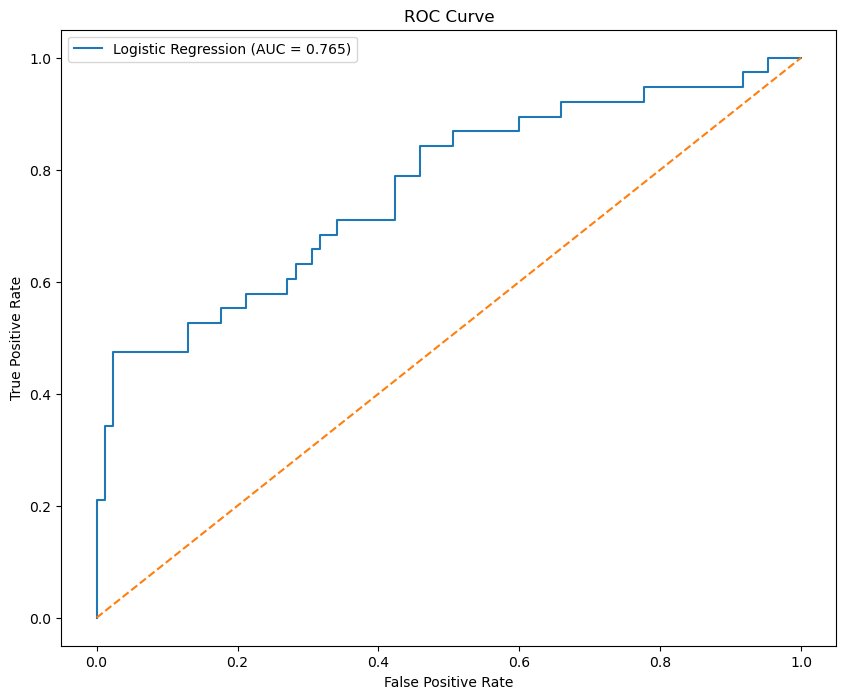

In [13]:
# ROC Curve plot

import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize = (10, 8))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**What this actually means?**

The threshold is conservative

The model prioritizes precision over recall

The bank is currently:

    Rejecting very few good customers (FP = 3)

    But missing many defaulters (FN = 20)

This is a policy decision (threshold of 50 %), not a modeling failure. 

In [14]:
# Train a helper function to evaluate a threshold

from sklearn.metrics import confusion_matrix, precision_score, recall_score

def evaluate_threshold(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return{
        'threshold': threshold,
        'precision_default': precision,
        'recall_default': recall,
        'confusion_matrix': cm
    } 

In [15]:
# Evaluate multiple thresholds

thresholds = [0.3, 0.4, 0.6, 0.7, 0.8]

results = []
for t in thresholds:
    results.append(evaluate_threshold(y_test, y_test_proba, t))

results

[{'threshold': 0.3,
  'precision_default': 0.5882352941176471,
  'recall_default': 0.5263157894736842,
  'confusion_matrix': array([[71, 14],
         [18, 20]])},
 {'threshold': 0.4,
  'precision_default': 0.75,
  'recall_default': 0.47368421052631576,
  'confusion_matrix': array([[79,  6],
         [20, 18]])},
 {'threshold': 0.6,
  'precision_default': 0.9,
  'recall_default': 0.47368421052631576,
  'confusion_matrix': array([[83,  2],
         [20, 18]])},
 {'threshold': 0.7,
  'precision_default': 0.9,
  'recall_default': 0.47368421052631576,
  'confusion_matrix': array([[83,  2],
         [20, 18]])},
 {'threshold': 0.8,
  'precision_default': 0.8947368421052632,
  'recall_default': 0.4473684210526316,
  'confusion_matrix': array([[83,  2],
         [21, 17]])}]

In [16]:
# Convert the results into a readable table

summary = []

for r in results:
    tn, fn, tp, fp = r['confusion_matrix'].ravel()
    summary.append({
        'threshold': r['threshold'],
        'precision_default': round(r['precision_default'], 2),
        'recall_default': round(r['recall_default'], 2),
        'false_positives': fp,
        'false_negatives': fn
    })

pd.DataFrame(summary)

,threshold,precision_default,recall_default,false_positives,false_negatives
0,0.3,0.59,0.53,20,14
1,0.4,0.75,0.47,18,6
2,0.6,0.90,0.47,18,2
3,0.7,0.90,0.47,18,2
4,0.8,0.89,0.45,17,2


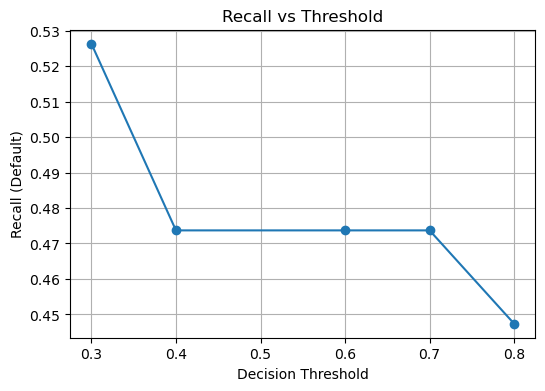

In [17]:
# Visualize recall vs threshold

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(
    [r["threshold"] for r in results],
    [r["recall_default"] for r in results],
    marker="o"
)
plt.xlabel("Decision Threshold")
plt.ylabel("Recall (Default)")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.show()

At a threshold of 0.5, the model is conservative and misses a significant number of defaulters.

Lowering the threshold increases recall for defaulted loans at the cost of rejecting more non-defaulting applicants.

A threshold around 0.4 provides a more balanced trade-off between risk capture and customer rejection, aligning better with a moderately risk-averse lending strategy.

In [20]:
# Comparing with other models like Naiye Bayes and KNN

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [23]:
# Naive Bayes: Train and Predict

nb = GaussianNB()
nb.fit(X_train_processed, y_train)

nb_test_proba = nb.predict_proba(X_test_processed)[:, 1]
nb_test_pred = (nb_test_proba >= 0.5).astype(int)

roc_auc_score(y_test, nb_test_proba)

np.float64(0.7219814241486067)

In [22]:
# Naive Bayes: Evaluation

print(confusion_matrix(y_test, nb_test_pred))
print(classification_report(y_test, nb_test_pred, target_names = ['Default', 'No Default']))

[[82  3]
 [20 18]]
              precision    recall  f1-score   support

     Default       0.80      0.96      0.88        85
  No Default       0.86      0.47      0.61        38

    accuracy                           0.81       123
   macro avg       0.83      0.72      0.74       123
weighted avg       0.82      0.81      0.79       123



In [24]:
# KNN: Train and Predict

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_processed, y_train)

knn_test_proba = knn.predict_proba(X_test_processed)[:, 1]
knn_test_pred = (knn_test_proba >= 0.5).astype(int)

roc_auc_score(y_test, knn_test_proba)

np.float64(0.7382352941176471)

In [25]:
# KNN: Evaluation

print(confusion_matrix(y_test, knn_test_pred))
print(classification_report(y_test, knn_test_pred, target_names = ['Default', 'No Default']))

[[78  7]
 [19 19]]
              precision    recall  f1-score   support

     Default       0.80      0.92      0.86        85
  No Default       0.73      0.50      0.59        38

    accuracy                           0.79       123
   macro avg       0.77      0.71      0.73       123
weighted avg       0.78      0.79      0.78       123



In [26]:
# Compare all the three models

comparison = pd.DataFrame({
    'Model': ['Logistic_Regression', 'Naive_Bayes', 'KNN'],
    'ROC_AUC': [
        roc_auc,
        roc_auc_score(y_test, nb_test_proba),
        roc_auc_score(y_test, knn_test_proba)
    ]
})

comparison

,Model,ROC_AUC
0,Logistic_Regression,0.764706
1,Naive_Bayes,0.721981
2,KNN,0.738235


Model comparison shows that while alternative algorithms such as Naive Bayes and KNN provide reasonable baselines, Logistic Regression offers the best balance between predictive performance, stability, and interpretability.

Given the regulatory and business constraints common in credit risk applications, Logistic Regression remains the preferred choice despite marginal differences in performance.